# Machine Learning on Distributed Dask with SageMaker and Fargate

This notebook will demonstrate how to perform Machine Learning on Distributed Dask using SageMaker and Fargate.  We will demo how to connect to distributed dask fargate cluster, scale out dask worker nodes, perform EDA work on public newyork cab trip data sets. Then, we demonstrate how you can run regression algorithms and hyperparameters optimization on distributed dask cluster. Next, we will demonstrate how you can monitor the operational metrics of Dask Cluster that will be fronted by Network Load Balancer for accessing the Dask Cluster Status UI from internet. Finally, we will close with how to build your own python script container and run against the dask fargate cluster.  This notebook was inspired by customer use case where they were running dask on local computer for building regression models.   

## Setup conda packages dependencies

In [3]:
!conda install scikit-learn=0.23.2 -c conda-forge -n python3 -y

Solving environment: done

# All requested packages already installed.



In [4]:
!conda install -n python3 dask-ml=1.6.0 -c conda-forge -y

Solving environment: done

# All requested packages already installed.



In [5]:
!conda install cloudpickle=1.6.0 -c conda-forge  -y

Solving environment: done

# All requested packages already installed.



## Connect to Dask Fargate Cluster.  You need to provision this cluster following the instructions from here https://github.com/rvvittal/aws-dask-sm-fargate

In [6]:
from dask.distributed import Client

#enable this client for local device testing
#client = Client()

#enable this client for local distributed cluster testing 
#client = Client('localhost:8786')

#enable this client for fargate distributed cluster testing
client = Client('Dask-Scheduler.local-dask:8786')

## Scale out the number of dask workers as needed for your data science work

In [7]:
#enable this  when cluster is running on Fargate to scale out your cluster. 
#!aws ecs update-service --service Dask-Workers --desired-count 5 --cluster Fargate-Dask-Cluster

## Restart the client after scale out operation

In [8]:
client.restart()

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 5 Cores: 10 Memory: 9.00 GB


## Introduction to Dask DataFrame
A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames. For more details, review this page: https://docs.dask.org/en/latest/dataframe.html 



In [9]:
import s3fs
import dask.dataframe as dd
import boto3


## Using Dask for EDA on NewYork Taxi Trip datasets

In [10]:
df = dd.read_csv(
    's3://nyc-tlc/trip data/green_tripdata_2018-02.csv', storage_options={'anon': True}
)

In [11]:
%%time
df.head()

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 8.23 s


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2018-02-01 00:39:38,2018-02-01 00:39:41,N,5,97,65,1,0.00,20.0,0.0,0.0,3.00,0.0,NaN,0.0,23.00,1,2
1,2,2018-02-01 00:58:28,2018-02-01 01:05:35,N,1,256,80,5,1.60,7.5,0.5,0.5,0.88,0.0,NaN,0.3,9.68,1,1
2,2,2018-02-01 00:56:05,2018-02-01 01:18:54,N,1,25,95,1,9.60,28.5,0.5,0.5,5.96,0.0,NaN,0.3,35.76,1,1
3,2,2018-02-01 00:12:40,2018-02-01 00:15:50,N,1,61,61,1,0.73,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,2,1
4,2,2018-02-01 00:45:18,2018-02-01 00:51:56,N,1,65,17,2,1.87,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1


In [12]:
# load and count number of rows
len(df)

769940

In [13]:
df.dtypes

VendorID                   int64
lpep_pickup_datetime      object
lpep_dropoff_datetime     object
store_and_fwd_flag        object
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
passenger_count            int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
ehail_fee                float64
improvement_surcharge    float64
total_amount             float64
payment_type               int64
trip_type                  int64
dtype: object

### TODO update this section to read multiple S3 files to demo the speed of parallel processing with dask dataframe on distributed cluster of nodes

import boto3
import os 

s3r = boto3.resource('s3', aws_access_key_id='xxxxxxxxxxxxxxxxx',
    aws_secret_access_key='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
bucket = s3r.Bucket('bucket_name')

prefix = 'dirname'
for object in bucket.objects.filter(Prefix = 'dirname'):
    if object.key == prefix:
        os.makedirs(os.path.dirname(object.key), exist_ok=True)
        continue;
    bucket.download_file(object.key, object.key)

## Persist  collections into memory
Calls to Client.compute or Client.persist submit task graphs to the cluster and return Future objects that point to particular output tasks. Compute returns a single future per input, persist returns a copy of the collection with each block or partition replaced by a single future. In short, use persist to keep full collection on the cluster and use compute when you want a small result as a single future.


In [14]:
df_persisted = client.persist(df)
print(df_persisted.head())

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2018-02-01 00:39:38   2018-02-01 00:39:41                  N   
1         2  2018-02-01 00:58:28   2018-02-01 01:05:35                  N   
2         2  2018-02-01 00:56:05   2018-02-01 01:18:54                  N   
3         2  2018-02-01 00:12:40   2018-02-01 00:15:50                  N   
4         2  2018-02-01 00:45:18   2018-02-01 00:51:56                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           5            97            65                1           0.00   
1           1           256            80                5           1.60   
2           1            25            95                1           9.60   
3           1            61            61                1           0.73   
4           1            65            17                2           1.87   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0  

## Compute the mean trip distance grouped by the number of passengers

In [15]:
grouped_df = df.groupby(df_persisted.passenger_count).trip_distance.mean().compute()
print(grouped_df)

passenger_count
0    2.248809
1    2.719773
2    2.800221
3    2.763138
4    2.660013
5    2.740212
6    2.653089
7    1.260000
8    1.013571
9    0.132500
Name: trip_distance, dtype: float64


## Compute Max trip distance

In [16]:
max_trip_dist = df_persisted.trip_distance.max().compute()
print(max_trip_dist)

120.47


## Count the total trip distance and count for each vendor

In [17]:
%%time
df.groupby('VendorID').agg({'passenger_count':'count', 'trip_distance': 'sum'}).astype(int).reset_index()\
.rename(columns={'passenger_count':'Trip Count'}).compute()

CPU times: user 32.5 ms, sys: 7.73 ms, total: 40.2 ms
Wall time: 5.19 s


,VendorID,Trip Count,trip_distance
0,1,131590,339995
1,2,638350,1758388


## Count Missing Values for Each Feature

In [18]:
df.isna().sum().compute()

VendorID                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag            0
RatecodeID                    0
PULocationID                  0
DOLocationID                  0
passenger_count               0
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                769940
improvement_surcharge         0
total_amount                  0
payment_type                  0
trip_type                     0
dtype: int64

##  Visual EDA  

In [19]:
##Selecting top 10 rides based on fare amount
most_paid_rides_dask = df[['PULocationID', 'fare_amount']].nlargest(10, "fare_amount")

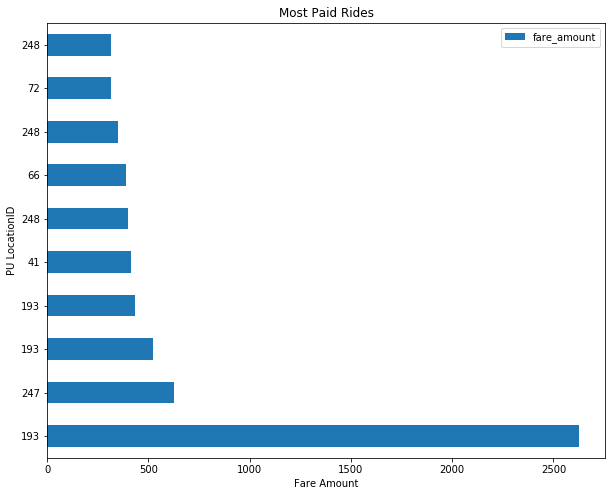

In [20]:
##Visualizing most paid rides through Barplot
import matplotlib.pyplot as plt
most_paid_rides_dask.set_index('PULocationID',sorted=True).compute().plot(kind='barh',stacked=False, figsize=[10,8], legend=True)
#######
plt.title('Most Paid Rides')
plt.xlabel('Fare Amount')
plt.ylabel('PU LocationID')
plt.show()


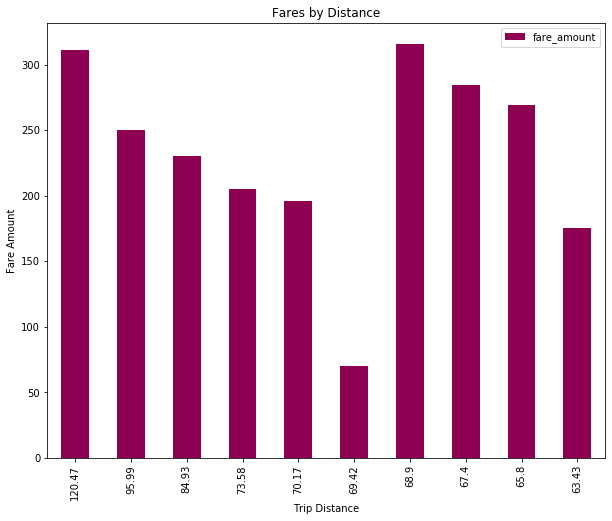

In [21]:
##Visualizing trip distance through Barplot
import matplotlib.pyplot as plt
most_paid_rides_dask2 = df[['trip_distance', 'fare_amount']].nlargest(10, "trip_distance")
most_paid_rides_dask2.set_index('trip_distance',sorted=True).compute().plot(kind='bar', colormap='PiYG', stacked=False, figsize=[10,8], legend=True)
#######
plt.title('Fares by Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

## Regression modeling with Scikit Learn

In [22]:
dfl = dd.read_csv(
    's3://nyc-tlc/trip data/green_tripdata_2018-02.csv', storage_options={'anon': True},
    parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime'],
).sample(frac=0.1, replace=True)

In [23]:
dfl['trip_duration'] = dfl['lpep_dropoff_datetime'] - dfl['lpep_pickup_datetime']

In [24]:
import numpy as np
dfl['trip_duration'] = dfl['trip_duration']/np.timedelta64(1,'D')

In [25]:
dfl['trip_duration'] = dfl['trip_duration'] * 24

In [26]:
dfl['trip_duration']

Dask Series Structure:
npartitions=2
    float64
        ...
        ...
Name: trip_duration, dtype: float64
Dask Name: getitem, 30 tasks

In [27]:
dfl.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,trip_duration
516835,2,2018-02-19 15:04:17,2018-02-19 15:27:14,N,1,166,186,1,6.53,23.0,0.0,0.5,3.57,0.0,NaN,0.3,27.37,1,1,0.382500
246249,2,2018-02-09 18:07:31,2018-02-09 18:14:05,N,1,7,7,4,0.67,6.0,1.0,0.5,0.00,0.0,NaN,0.3,7.80,2,1,0.109444
7704,2,2018-02-01 10:24:39,2018-02-01 10:40:21,N,1,78,185,1,2.88,13.0,0.0,0.5,0.00,0.0,NaN,0.3,13.80,1,1,0.261667
426589,2,2018-02-16 10:07:28,2018-02-16 10:09:50,N,1,41,41,1,0.48,4.0,0.0,0.5,0.96,0.0,NaN,0.3,5.76,1,1,0.039444
145179,2,2018-02-06 02:52:00,2018-02-06 03:01:19,N,1,25,25,1,1.17,7.5,0.5,0.5,0.00,0.0,NaN,0.3,8.80,2,1,0.155278


In [28]:
dfl = dfl.fillna(value=0)

In [29]:
dfl = dd.get_dummies(dfl.categorize()).compute()

In [30]:
dfl.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y
516835,2,2018-02-19 15:04:17,2018-02-19 15:27:14,1,166,186,1,6.53,23.0,0.0,...,3.57,0.0,0.0,0.3,27.37,1,1,0.382500,1,0
246249,2,2018-02-09 18:07:31,2018-02-09 18:14:05,1,7,7,4,0.67,6.0,1.0,...,0.00,0.0,0.0,0.3,7.80,2,1,0.109444,1,0
7704,2,2018-02-01 10:24:39,2018-02-01 10:40:21,1,78,185,1,2.88,13.0,0.0,...,0.00,0.0,0.0,0.3,13.80,1,1,0.261667,1,0
426589,2,2018-02-16 10:07:28,2018-02-16 10:09:50,1,41,41,1,0.48,4.0,0.0,...,0.96,0.0,0.0,0.3,5.76,1,1,0.039444,1,0
145179,2,2018-02-06 02:52:00,2018-02-06 03:01:19,1,25,25,1,1.17,7.5,0.5,...,0.00,0.0,0.0,0.3,8.80,2,1,0.155278,1,0


In [31]:
x = dfl[['VendorID','RatecodeID','PULocationID','DOLocationID','passenger_count','trip_distance','fare_amount','total_amount']]

In [32]:
y = dfl['trip_duration']

In [33]:
from dask_ml.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [35]:
len(X_train), len(X_test), len(y_train), len(y_test)

(69294, 7700, 69294, 7700)

In [36]:
training_x = X_train.values
training_y = y_train.values

In [37]:
testing_x = X_test.values
testing_y = y_test.values

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [39]:
def rmse(preds, actuals):
    error = mean_squared_error(actuals, preds)
    rmse = np.sqrt(error)
    print(rmse)

In [40]:
from dask_ml.linear_model import LinearRegression
lr = LinearRegression(random_state=1, n_jobs=-1, fit_intercept=True)
lr.fit(training_x,training_y)

LinearRegression(n_jobs=-1, random_state=1)

In [41]:
import joblib
from dask_ml.linear_model import LinearRegression

with joblib.parallel_backend('dask'):
    lr = LinearRegression(random_state=1, fit_intercept=False)
    lr.fit(training_x,training_y)

In [42]:
lr.predict(testing_x)

array([0.53538047, 0.28755367, 0.70070166, ..., 0.4628575 , 0.25166726,
       0.21636435])

## Linear Regression with Dask distributed machine learning

In [43]:
from dask_glm.datasets import make_regression
X, y = make_regression(n_samples=200000, n_features=100, n_informative=5, chunksize=10000)
X


dask.array<normal, shape=(200000, 100), dtype=float64, chunksize=(10000, 100), chunktype=numpy.ndarray>

In [44]:
import dask
X, y = dask.persist(X, y)

In [45]:
import dask_glm.algorithms

b = dask_glm.algorithms.admm(X, y, max_iter=5)

In [46]:
b

array([-0.00243338, -0.00232949, -0.00564347,  0.        , -0.00313042,
        0.00181366,  0.00141414,  0.        , -0.00375001, -0.0037615 ,
        0.        ,  0.        , -0.00509192,  0.        ,  0.        ,
        0.        , -0.00039387, -0.00246486,  0.        ,  0.00237348,
        0.00213498,  0.00352001, -0.00137245,  0.        ,  0.        ,
       -0.00286902, -0.00178535,  0.        ,  0.00181183, -0.00346849,
       -0.00215373, -0.00217845, -0.00764952,  0.00057924, -0.00045162,
        0.        , -0.00248635,  0.00478814,  0.00302438, -0.00142484,
        0.00591568,  0.        ,  0.        ,  0.00232022, -0.00018923,
        0.        ,  0.        ,  0.00294387, -0.00219608,  0.        ,
       -0.00281381,  0.00140012, -0.00441833,  0.        ,  0.        ,
        0.00393908, -0.00372148,  0.        ,  0.        ,  0.00413716,
        0.        ,  0.00187437,  0.00291577,  0.00204651, -0.00600623,
        0.00408   ,  0.        ,  0.00185827, -0.00220777, -0.00

In [47]:
b = dask_glm.algorithms.proximal_grad(X, y, max_iter=5)

In [48]:
b

array([-2.32290061e-03, -2.32327614e-03, -5.96564911e-03, -1.06445415e-03,
       -2.79791914e-03,  2.10748242e-03,  1.28055600e-03, -9.45491927e-04,
       -3.64269701e-03, -3.58058796e-03,  8.60530417e-04, -9.68301038e-05,
       -4.64024679e-03,  1.26391826e-04, -6.28589342e-04, -1.28281829e-04,
       -1.13647505e-03, -2.03861287e-03,  7.11093074e-05,  2.33871814e-03,
        2.11048193e-03,  3.66998309e-03, -1.02012956e-03,  1.48283924e-04,
       -4.72892431e-04, -2.66923722e-03, -2.08747705e-03, -1.23964671e-04,
        1.60921929e-03, -3.60865114e-03, -2.07405821e-03, -1.84150272e-03,
       -7.33947980e-03,  9.85190491e-04, -1.73404424e-03, -1.64330514e-05,
       -2.28525334e-03,  5.04084199e-03,  3.07562056e-03, -1.05102263e-03,
        5.34053394e-03,  8.77447650e-04,  8.51408188e-05,  2.46986088e-03,
       -1.08061192e-03,  5.93204820e-04,  7.92605193e-04,  2.78653608e-03,
       -2.58526128e-03, -5.49289558e-04, -2.80865411e-03,  1.20505405e-03,
       -4.51993700e-03,  

In [49]:
import dask_glm.families
import dask_glm.regularizers

family = dask_glm.families.Poisson()
regularizer = dask_glm.regularizers.ElasticNet()

b = dask_glm.algorithms.proximal_grad(
    X, y,
    max_iter=5,
    family=family,
    regularizer=regularizer,
)


In [50]:
b

array([-5.46505484e-04, -1.37638025e-03, -3.40389170e-04,  1.22156983e-03,
       -5.02826199e-04,  4.40888282e-04, -9.79871835e-05,  4.64377040e-04,
       -1.70687375e-04, -4.38750910e-04,  3.79939146e-04,  2.50498419e-03,
       -9.90411191e-04, -2.68624672e-05,  1.27754342e-03, -7.44393705e-04,
        1.74048052e-05,  1.46061679e-04, -4.48422824e-04,  1.99900126e-03,
       -3.48881656e-04,  5.86144825e-04,  1.12914742e-05,  4.98641393e-04,
       -4.10344431e-05,  1.15961567e-03, -4.67072526e-04, -2.03322123e-03,
       -1.40410391e-03, -1.19648771e-04, -2.37094756e-03, -5.23468362e-04,
       -3.34710327e-03,  3.23795569e-04, -6.05598181e-04,  6.91995781e-04,
       -1.21251282e-03,  8.93704934e-04,  7.43037406e-04, -9.17525081e-04,
        5.95295252e-04, -1.38688259e-03, -4.13968208e-04,  2.11579631e-03,
        2.51389370e-03, -1.84276000e-04,  8.04660972e-04,  4.95650808e-04,
        4.86444636e-04,  5.60169629e-04, -4.55922097e-04, -1.08203594e-03,
       -7.21486678e-04, -

## Hyperparameter Optimization with Dask distributed machine learning

Scikit-learn uses joblib for single-machine parallelism. This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your laptop or workstation.Alternatively, Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code.

In [51]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd


In [52]:
X, y = make_classification(n_samples=1000, random_state=0)
X[:5]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644],
       [ 0.94028404, -0.49214582,  0.67795602, -0.22775445,  1.40175261,
         1.23165333, -0.77746425,  0.01561602,  1.33171299,  1.08477266,
        -0.97805157, -0.05012039,  0.94838552, -0.17342825, -0.47767184,
         0.76089649,  1.00115812, -0.06946407,  1.35904607, -1.18958963],
       [-0.29951677,  0.75988955,  0.18280267, -1.55023271,  0.33821802,
         0.36324148, -2.10052547, -0.4380675 , -

In [53]:
y[:5]

array([0, 1, 1, 1, 0])

In [54]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)


In [55]:
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]})

In [ ]:
pd.DataFrame(grid_search.cv_results_).head()

## Run your python script container for your machine learning work.  

Make sure to follow the steps in github repo for building/deploying this container before running this step. Change {YOURACCOUNTID} to your account id

In [ ]:
!aws ecr get-login-password --region us-west-2 | docker login --username AWS --password-stdin {YOURACCOUNTID}.dkr.ecr.us-west-2.amazonaws.com

In [ ]:
!docker run -e s3url='s3://nyc-tlc/trip data/green_tripdata_2018-02.csv' -e schurl='tcp://Dask-Scheduler.local-dask:8786' {YOURACCOUNTID}.dkr.ecr.us-west-2.amazonaws.com/daskclientapp:latest

## Scale in the Fargate cluster worker nodes after all work is done

In [ ]:
!aws ecs update-service --service Dask-Workers --desired-count 1 --cluster Fargate-Dask-Cluster